In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-darkgrid")

# 1ra Etapa: Análisis exploratorio de los datos

## Tabla Pedidos

In [178]:
pedidos = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "OrderList")

pedidos.columns = ["Pedido", "Fecha", "Puerto de origen", "Transportista", "TPT", "Nivel de servicio", "Envío adelantado [días]", 
                   "Envío tardío [días]", "Cliente", "Producto", "Planta", "Puerto de destino", "Items", "Peso [kg/item]"]

In [179]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Pedido                   9215 non-null   float64       
 1   Fecha                    9215 non-null   datetime64[ns]
 2   Puerto de origen         9215 non-null   object        
 3   Transportista            9215 non-null   object        
 4   TPT                      9215 non-null   int64         
 5   Nivel de servicio        9215 non-null   object        
 6   Envío adelantado [días]  9215 non-null   int64         
 7   Envío tardío [días]      9215 non-null   int64         
 8   Cliente                  9215 non-null   object        
 9   Producto                 9215 non-null   int64         
 10  Planta                   9215 non-null   object        
 11  Puerto de destino        9215 non-null   object        
 12  Items                    9215 non-

In [180]:
pedidos["Pedido"] = pedidos["Pedido"].astype(int)
pedidos[["Puerto de origen", "Planta", "Puerto de destino"]] = pedidos[["Puerto de origen", "Planta", "Puerto de destino"]].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

pedidos.head()

,Pedido,Fecha,Puerto de origen,Transportista,TPT,Nivel de servicio,Envío adelantado [días],Envío tardío [días],Cliente,Producto,Planta,Puerto de destino,Items,Peso [kg/item]
0,1447296446,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,808,14.30
1,1447158014,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,3188,87.94
2,1447138898,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,2331,61.20
3,1447363527,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,847,16.16
4,1447363980,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,2163,52.34


*¿Cuántas filas y columnas tiene esta tabla?*

In [181]:
pedidos.shape

(9215, 14)

*¿Cuándo se realizaron los pedidos?*

In [182]:
d = pedidos["Fecha"].unique().astype("datetime64[D]").astype(str)
d[0]

'2013-05-26'

*¿Cuál es el total de pedidos en esa fecha?*

In [183]:
pedidos.shape[0]

9215

*¿Cuántos pedidos hubo por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [184]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Pedido": "size"})
pedidos_agrup = pedidos_agrup.rename(columns = {"Pedido": "Recuento de Pedidos"})

total = pedidos_agrup["Recuento de Pedidos"].sum()
porcentaje = lambda x: x / total * 100

pedidos_agrup["%"] = pedidos_agrup["Recuento de Pedidos"].apply(porcentaje)
pedidos_agrup.round(2)

,,,Recuento de Pedidos,%
Planta,Puerto de origen,Puerto de destino,,
3,4,9,8541,92.69
4,5,9,1,0.01
8,4,9,102,1.11
9,4,9,12,0.13
12,4,9,300,3.26
13,4,9,86,0.93
16,9,9,173,1.88


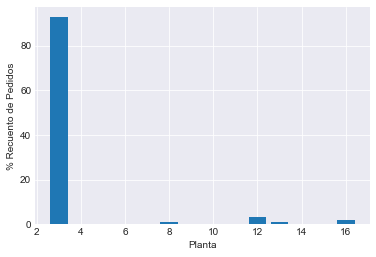

In [185]:
plt.figure(1)
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup["%"])
plt.xlabel("Planta")
plt.ylabel("% Recuento de Pedidos");

*¿Cuántos items hubo por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [186]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Items": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Items", "sum")].sum()
porcentaje = lambda x: x / total * 100

pedidos_agrup[("Items", "%")] = pedidos_agrup[("Items", "sum")].apply(porcentaje)
pedidos_agrup.round(2)

Items                              \
                                            min      mean     max       std   
Planta Puerto de origen Puerto de destino                                     
3      4                9                   235   3349.91  561847  16525.97   
4      5                9                   348    348.00     348       NaN   
8      4                9                   684   2715.76    5680   1504.06   
9      4                9                  2301  18652.50  101069  28877.08   
12     4                9                   236    373.33    1321    169.36   
13     4                9                   240    504.41    5244    609.10   
16     9                9                   280   1416.95    4464   1121.49   

                                                            
                                                sum      %  
Planta Puerto de origen Puerto de destino                   
3      4                9                  28611617  96.94  
4      5                9                       348   0.00  
8      4                9                    277008   0.94  
9      4                9                    223830   0.76  
12     4                9                    112000   0.38  
13     4                9                     43379   0.15  
16     9                9                    245133   0.83

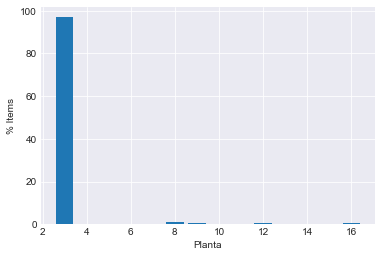

In [187]:
plt.figure(1)
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup[("Items", "%")])
plt.xlabel("Planta")
plt.ylabel("% Items");

*Estadística descriptiva de Peso [kg/items] por cada conjunto Planta, Puerto de origen y Puerto de destino*

In [188]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Peso [kg/item]": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Peso [kg/item]", "sum")].sum()
porcentaje = lambda x: x / total * 100

pedidos_agrup[("Peso [kg/item]", "%")] = pedidos_agrup[("Peso [kg/item]", "sum")].apply(porcentaje)
pedidos_agrup.round(2)

Peso [kg/item]                   \
                                                     min    mean      max   
Planta Puerto de origen Puerto de destino                                   
3      4                9                           0.00   15.86  1356.76   
4      5                9                           2.10    2.10     2.10   
8      4                9                           2.29   14.50    43.64   
9      4                9                           5.35   33.86   171.92   
12     4                9                           0.26   27.16   325.96   
13     4                9                           0.35   63.12   946.50   
16     9                9                           0.61  185.94  2338.41   

                                                                     
                                              std        sum      %  
Planta Puerto de origen Puerto de destino                            
3      4                9                   50.20  135486.51  73.99  
4      5                9                     NaN       2.10   0.00  
8      4                9                   10.37    1478.79   0.81  
9      4                9                   48.35     406.36   0.22  
12     4                9                   52.33    8147.43   4.45  
13     4                9                  127.13    5428.39   2.96  
16     9                9                  264.06   32168.01  17.57

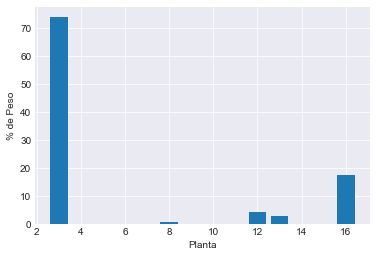

In [189]:
plt.figure(1)
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup[("Peso [kg/item]", "%")])
plt.xlabel("Planta")
plt.ylabel("% de Peso");

*¿Hay alguna correlación entre Peso [kg/items] e Items?*

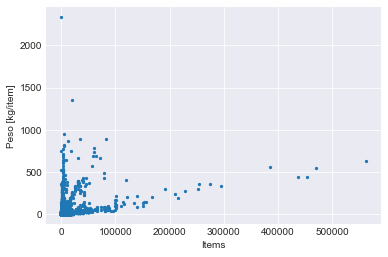

In [190]:
plt.figure(1)
plt.scatter(pedidos["Items"], pedidos["Peso [kg/item]"], s = 5)
plt.xlabel("Items")
plt.ylabel("Peso [kg/item]");

In [191]:
from scipy.stats import pearsonr 

r2, pvalue = pearsonr(x = pedidos["Items"], y = pedidos["Peso [kg/item]"])
round(r2, 3)

0.345

## Tabla Fletes

In [192]:
fletes = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "FreightRates")

fletes.columns = ["Transportista", "Puerto de origen", "Puerto de destino", "Peso mínimo [kg/item]", "Peso máximo [kg/item]", 
                  "Nivel de servicio", "Costo mínimo [USD/kg]", "Tasa de flete [USD/kg]", "Modo de transporte", "Envío [días]", 
                  "Tipo de transportista"]

In [193]:
fletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transportista           1540 non-null   object 
 1   Puerto de origen        1540 non-null   object 
 2   Puerto de destino       1540 non-null   object 
 3   Peso mínimo [kg/item]   1540 non-null   float64
 4   Peso máximo [kg/item]   1540 non-null   float64
 5   Nivel de servicio       1540 non-null   object 
 6   Costo mínimo [USD/kg]   1540 non-null   float64
 7   Tasa de flete [USD/kg]  1540 non-null   float64
 8   Modo de transporte      1540 non-null   object 
 9   Envío [días]            1540 non-null   int64  
 10  Tipo de transportista   1540 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 132.5+ KB


In [194]:
fletes[["Puerto de origen", "Puerto de destino"]] = fletes[["Puerto de origen", "Puerto de destino"]].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)
fletes["Modo de transporte"] = fletes["Modo de transporte"].replace({"AIR   ": "Aire", "GROUND": "Tierra"}, regex = True)

fletes.head()

,Transportista,Puerto de origen,Puerto de destino,Peso mínimo [kg/item],Peso máximo [kg/item],Nivel de servicio,Costo mínimo [USD/kg],Tasa de flete [USD/kg],Modo de transporte,Envío [días],Tipo de transportista
0,V444_6,8,9,250.0,499.99,DTD,43.2272,0.7132,Aire,2,V88888888_0
1,V444_6,8,9,65.0,69.99,DTD,43.2272,0.7512,Aire,2,V88888888_0
2,V444_6,8,9,60.0,64.99,DTD,43.2272,0.7892,Aire,2,V88888888_0
3,V444_6,8,9,50.0,54.99,DTD,43.2272,0.8272,Aire,2,V88888888_0
4,V444_6,8,9,35.0,39.99,DTD,43.2272,1.0552,Aire,2,V88888888_0


*¿Cuántas filas y columnas tiene esta tabla?*

In [195]:
fletes.shape

(1540, 11)

*Estadística descriptiva de Tasa de flete [USD/kg] para cada conjunto Puerto de origen y Puerto de destino*

In [196]:
fletes_agrup = fletes.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Tasa de flete [USD/kg]": ["min", "mean", "max", "std"]})
fletes_agrup.round(2)

Tasa de flete [USD/kg]                     
                                                      min  mean     max    std
Puerto de origen Puerto de destino                                            
2                9                                   0.05  1.87    7.06   1.78
3                9                                   0.12  9.98  128.03  19.30
4                9                                   0.04  1.94    7.66   2.05
5                9                                   0.07  2.87   12.07   2.90
6                9                                   0.07  2.53    7.16   1.74
7                9                                   0.14  0.20    0.28   0.04
8                9                                   0.10  0.59    1.83   0.56
9                9                                   0.03  2.84   21.28   6.59
10               9                                   0.10  5.37   18.96   4.99
11               9                                   0.07  0.13    0.34   0.06

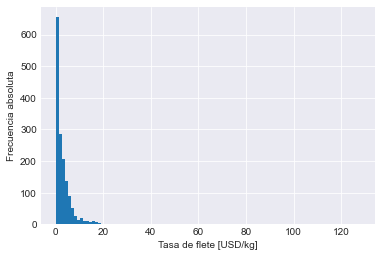

In [197]:
plt.figure(1)
plt.hist(fletes["Tasa de flete [USD/kg]"], bins = 100)
plt.xlabel("Tasa de flete [USD/kg]")
plt.ylabel("Frecuencia absoluta");

*Estadística descriptiva de Envío [días] para cada conjunto Puerto de origen y Puerto de destino*

In [198]:
fletes_agrup = fletes.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Envío [días]": ["min", "mean", "max", "size"]})
fletes_agrup.round(2)

Envío [días]               
                                            min  mean max size
Puerto de origen Puerto de destino                            
2                9                            0  1.62  14  226
3                9                            0  2.91  14   45
4                9                            0  1.58  14  231
5                9                            1  1.27   4  219
6                9                            1  1.99   3  479
7                9                            3  4.50   6   20
8                9                            2  4.82  14   39
9                9                            0  4.42  14   24
10               9                            2  3.17   6  222
11               9                            0  5.29  14   35

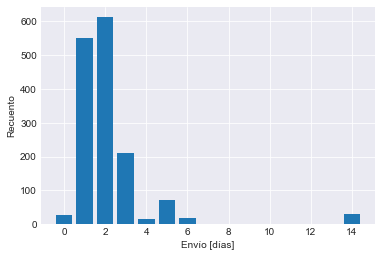

In [199]:
fletes_agrup = fletes.groupby(by = "Envío [días]").agg({"Envío [días]": "size"}).rename(columns = {"Envío [días]": "Recuento"})

plt.figure(1)
plt.bar(x = fletes_agrup.index, height = fletes_agrup["Recuento"])
plt.xlabel("Envío [días]")
plt.ylabel("Recuento");

*Estadística descriptiva de Modo de Transporte*

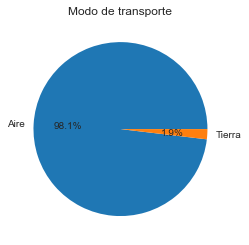

In [200]:
fletes_agrup = fletes.groupby(by = "Modo de transporte").agg({"Puerto de origen": "size"})
fletes_agrup = fletes_agrup.rename(columns = {"Puerto de origen": "Recuento de Puerto de origen"})

plt.figure(1)
plt.title("Modo de transporte")
plt.pie(x = fletes_agrup["Recuento de Puerto de origen"], labels = fletes_agrup.index, autopct = "%1.1f%%");

## Tabla Costos de Almacenaje

In [201]:
costos_almacenaje = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "WhCosts")

costos_almacenaje.columns = ["Planta", "Costo específico [USD/item]"]

In [202]:
costos_almacenaje.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Planta                       19 non-null     object 
 1   Costo específico [USD/item]  19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 432.0+ bytes


In [203]:
costos_almacenaje["Planta"] = costos_almacenaje["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

costos_almacenaje.head().round(2)

,Planta,Costo específico [USD/item]
0,15,1.42
1,17,0.43
2,18,2.04
3,5,0.49
4,2,0.48


*Estadística descriptiva de Costo específico [USD/item]*

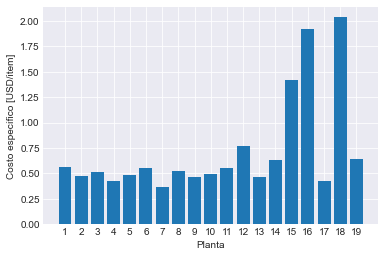

In [204]:
plt.figure(1)
plt.bar(x = costos_almacenaje["Planta"], height = costos_almacenaje["Costo específico [USD/item]"])
plt.xlabel("Planta")
plt.xticks(costos_almacenaje["Planta"])
plt.ylabel("Costo específico [USD/item]");

## Tabla Capacidad de Almacenaje

In [205]:
capacidad_almacenaje = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "WhCapacities")

capacidad_almacenaje.columns = ["Planta", "Capacidad [pedidos/día]"]

In [206]:
capacidad_almacenaje.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Planta                   19 non-null     object
 1   Capacidad [pedidos/día]  19 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes


In [207]:
capacidad_almacenaje["Planta"] = capacidad_almacenaje["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

capacidad_almacenaje.head().round(2)

,Planta,Capacidad [pedidos/día]
0,15,11
1,17,8
2,18,111
3,5,385
4,2,138


*Estadística descriptiva de Capacidad [items/día]*

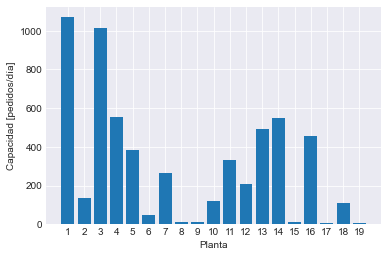

In [208]:
plt.figure(1)
plt.bar(x = capacidad_almacenaje["Planta"], height = capacidad_almacenaje["Capacidad [pedidos/día]"])
plt.xlabel("Planta")
plt.xticks(capacidad_almacenaje["Planta"])
plt.ylabel("Capacidad [pedidos/día]");

## Tabla Productos por cada Planta

In [209]:
productos_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "ProductsPerPlant")

productos_por_planta.columns = ["Planta", "Producto"]

In [210]:
productos_por_planta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Planta    2036 non-null   object
 1   Producto  2036 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.9+ KB


In [211]:
productos_por_planta["Planta"] = productos_por_planta["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

productos_por_planta.head()

,Planta,Producto
0,15,1698815
1,17,1664419
2,17,1664426
3,17,1672826
4,17,1674916


*Estadística descriptiva de Recuento de Productos*

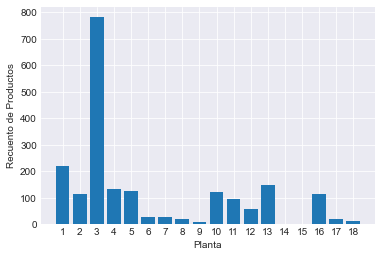

In [212]:
productos_agrup_por_planta = productos_por_planta.groupby(by = "Planta").agg({"Planta": "size"})
productos_agrup_por_planta = productos_agrup_por_planta.rename(columns = {"Planta": "Recuento de Productos"})

plt.figure(1)
plt.bar(x = productos_agrup_por_planta.index, height = productos_agrup_por_planta["Recuento de Productos"])
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Productos");

## Tabla Clientes por cada Planta

In [213]:
clientes_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "VmiCustomers")

clientes_por_planta.columns = ["Planta", "Cliente"]

In [214]:
clientes_por_planta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Planta   14 non-null     object
 1   Cliente  14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


In [215]:
clientes_por_planta["Planta"] = clientes_por_planta["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

clientes_por_planta.head()

,Planta,Cliente
0,2,V5555555555555_16
1,2,V555555555555555_29
2,2,V555555555_3
3,2,V55555555555555_8
4,2,V55555555_9


*Estadística descriptiva de Clientes por cada Planta*

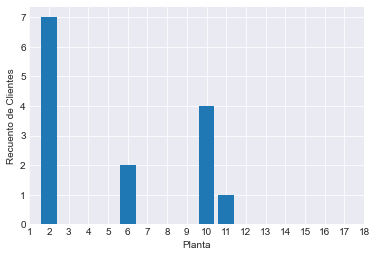

In [216]:
clientes_agrup_por_planta = clientes_por_planta.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Clientes"})

plt.figure(1)
plt.bar(x = clientes_agrup_por_planta.index, height = clientes_agrup_por_planta["Recuento de Clientes"])
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Clientes");

## Tabla Puertos por cada Planta

In [217]:
puertos_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "PlantPorts").iloc[:, :2]

puertos_por_planta.columns = ["Planta", "Puerto de Origen"]

In [218]:
puertos_por_planta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Planta            22 non-null     object
 1   Puerto de Origen  22 non-null     object
dtypes: object(2)
memory usage: 480.0+ bytes


In [219]:
puertos_por_planta[["Planta", "Puerto de Origen"]] = puertos_por_planta[["Planta", "Puerto de Origen"]].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

puertos_por_planta.head()

,Planta,Puerto de Origen
0,1,1
1,1,2
2,2,3
3,3,4
4,4,5


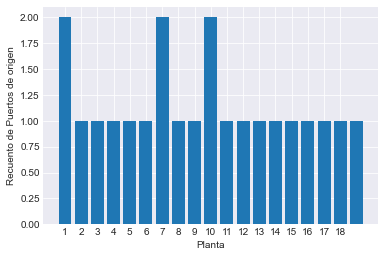

In [220]:
puertos_agrup_por_planta = puertos_por_planta.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Puertos de origen"})

plt.figure(1)
plt.bar(x = puertos_agrup_por_planta.index, height = puertos_agrup_por_planta["Recuento de Puertos de origen"])
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Puertos de origen");

# 2da Etapa: Optimización

*Función Objetivo*\
Se desea conocer un conjunto de plantas de almacenaje, puertos de origen y puertos de destino que minimicen el costo total de la cadena de suministro.

Nomenclatura:
- k: ID de pedido
- i: ID de planta de almacenamiento
- p: ID de puerto de origen
- j: ID de puerto de destino
- c: ID de transportista
- s: Nivel de servicio
- t: Tiempo de envío [días]
- m: Modo de transporte (aire o tierra)
- q: Cantidad de items en cada pedido [items]

- C: Costo de almacenamiento [USD/item]
- M: Costo fijo de transporte [USD/kg]
- X: Costo de almacenamiento [USD]
- Y: Costo de transporte [USD/kg]
- Z: Costo total de la cadena de suministro [USD]

In [221]:
df1 = pd.merge(pedidos, fletes, on = ["Puerto de origen", "Puerto de destino", "Transportista", "Nivel de servicio"])
df2 = pd.merge(df1, costos_almacenaje, on = ["Planta"])
df3 = pd.merge(df2, capacidad_almacenaje, on = ["Planta"])

df3.head().round(2)

,Pedido,Fecha,Puerto de origen,Transportista,TPT,Nivel de servicio,Envío adelantado [días],Envío tardío [días],Cliente,Producto,...,Peso [kg/item],Peso mínimo [kg/item],Peso máximo [kg/item],Costo mínimo [USD/kg],Tasa de flete [USD/kg],Modo de transporte,Envío [días],Tipo de transportista,Costo específico [USD/item],Capacidad [pedidos/día]
0,1447385217,2013-05-26,9,V444_0,0,DTP,0,0,V55555_4,1692724,...,1.02,0.0,5000.0,31.28,12.28,Tierra,0,V88888888_0,1.92,457
1,1447337778,2013-05-26,9,V444_0,0,DTP,0,0,V55555_4,1692724,...,0.61,0.0,5000.0,31.28,12.28,Tierra,0,V88888888_0,1.92,457
2,1447406947,2013-05-26,9,V444_0,0,DTP,3,0,V555555_6,1692722,...,37.04,0.0,5000.0,31.28,12.28,Tierra,0,V88888888_0,1.92,457
3,1447154164,2013-05-26,9,V444_0,0,DTP,3,0,V555555_6,1692722,...,42.83,0.0,5000.0,31.28,12.28,Tierra,0,V88888888_0,1.92,457
4,1447163388,2013-05-26,9,V444_0,0,DTP,3,0,V555555_6,1692722,...,133.22,0.0,5000.0,31.28,12.28,Tierra,0,V88888888_0,1.92,457


*¿Cuántas filas y columnas tiene la nueva tabla?*

In [222]:
df3.shape

(146214, 23)

*Estadística Descriptiva del Costo de Almacenaje [USD]*

$$ w_{ikpjcstm} \leq F_{ikpjcstm} $$

In [223]:
g3 = df3.groupby(by = "Planta").agg({"Pedido": "size", "Capacidad [pedidos/día]": "mean"}).rename(columns = {"Pedido": "Cantidad [pedidos/día]"})
g3["Cantidad real [pedidos/día]"] = np.where(g3["Cantidad [pedidos/día]"] < g3["Capacidad [pedidos/día]"], g3["Cantidad [pedidos/día]"], 
                                             g3["Capacidad [pedidos/día]"])

g3

,Cantidad [pedidos/día],Capacidad [pedidos/día],Cantidad real [pedidos/día]
Planta,,,
3,137800,1013,1013
8,1010,14,14
9,120,11,11
12,6390,209,209
13,860,490,490
16,34,457,34


$$ X_{ki} = q_{ki}*C_i $$

In [224]:
df3["Costo de almacenaje [USD]"] = df3["Items"] * df3["Costo específico [USD/item]"]
df3_agrup = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo de almacenaje [USD]": ["min", "mean", "max", "sum"]})

total = df3_agrup[("Costo de almacenaje [USD]", "sum")].sum()
porcentaje = lambda x: x / total * 100

df3_agrup[("Costo de almacenaje [USD]", "%")] = df3_agrup[("Costo de almacenaje [USD]", "sum")].apply(porcentaje)
df3_agrup.round(2)

Costo de almacenaje [USD]           \
                                                                min     mean   
Planta Puerto de origen Puerto de destino                                      
3      4                9                                    121.61  1170.68   
8      4                9                                    357.63  1430.16   
9      4                9                                   1070.13  8674.74   
12     4                9                                    182.46   291.55   
13     4                9                                    112.73   236.92   
16     9                9                                    539.47   703.10   

                                                                           
                                                 max           sum      %  
Planta Puerto de origen Puerto de destino                                  
3      4                9                  290756.89  1.613191e+08  97.24  
8      4                9                    2969.83  1.444466e+06   0.87  
9      4                9                   47004.27  1.040969e+06   0.63  
12     4                9                    1021.31  1.862992e+06   1.12  
13     4                9                    2463.14  2.037542e+05   0.12  
16     9                9                    1581.92  2.390544e+04   0.01

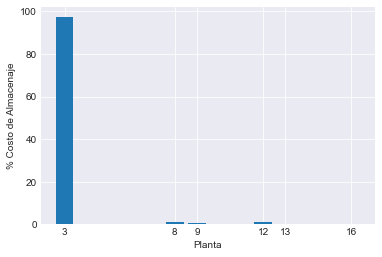

In [225]:
plt.figure(1)
plt.bar(x = df3_agrup.index.levels[0], height = df3_agrup[("Costo de almacenaje [USD]", "%")])
plt.xlabel("Planta")
plt.xticks(df3_agrup.index.levels[0])
plt.ylabel("% Costo de Almacenaje");

*Estadística Descriptiva del Costo de Transporte [USD]*

$$ Si \ Y_{ikpjcstm} < M_{ikpjcstm} \ \Rightarrow \ Y_{ikpjcstm} = M_{ikpjcstm} $$

$$ Si \ s = CRF \ \Rightarrow \ Y_{ikpjcstm} = 0 $$

$$ Si \ s \neq CRF, \ m = Tierra \ \Rightarrow \ Y_{ikpjcstm} = \frac{w_{ikpjcstm}}{\sum_{i}{...\sum_{m}{w_{ikpjcstm}}}}*R_{ikpjcstm} $$

$$ Si \ s \neq CRF, \ m \neq Tierra \ \Rightarrow \ Y_{ikpjcstm} = w_{ikpjcstm}*R_{ikpjcstm} $$

In [226]:
df3["Peso [kg]"] = df3["Items"] * df3["Peso [kg/item]"]
df3["Peso máximo [kg]"] = df3["Items"] * df3["Peso máximo [kg/item]"]
df3["Peso real [kg]"] = np.where(df3["Peso [kg]"] < df3["Peso máximo [kg]"], df3["Peso [kg]"], df3["Peso máximo [kg]"])

a = df3["Peso real [kg]"] / df3["Peso real [kg]"].sum() * df3["Tasa de flete [USD/kg]"]
b = df3["Peso real [kg]"] * df3["Tasa de flete [USD/kg]"]
c = df3["Costo mínimo [USD/kg]"]

df3["Costo de transporte [USD]"] = np.where(df3["Nivel de servicio"] == "CRF", 0, 
                                            np.where(df3["Modo de transporte"] == "Tierra", np.where(a > c, a, c),
                                                    np.where(b > c, b, c)))

df3[["Planta", "Puerto de origen", "Puerto de destino", "Peso [kg]", "Peso máximo [kg]", 
     "Peso real [kg]", "Costo de transporte [USD]"]].sample(10).round(2)

,Planta,Puerto de origen,Puerto de destino,Peso [kg],Peso máximo [kg],Peso real [kg],Costo de transporte [USD]
110139,3,4,9,4293.00,37496.25,4293.00,345.16
70003,3,4,9,330.07,3729996.27,330.07,95.23
8783,3,4,9,539.55,42295.77,539.55,26.11
131723,3,4,9,31710.08,7169992.83,31710.08,2359.23
118627,3,4,9,423.50,644.00,423.50,161.10
86903,3,4,9,70061.55,20309979.69,70061.55,5212.58
82233,3,4,9,244.96,2709997.29,244.96,101.83
4762,12,4,9,705.42,265997.34,705.42,53.61
13305,3,4,9,47.56,59747.61,47.56,2.02
38105,3,4,9,555.86,143744.25,555.86,23.57


In [227]:
df3_agrup = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo de transporte [USD]": ["min", "mean", "max", "sum"]})

total = df3_agrup[("Costo de transporte [USD]", "sum")].sum()
porcentaje = lambda x: x / total * 100

df3_agrup[("Costo de transporte [USD]", "%")] = df3_agrup[("Costo de transporte [USD]", "sum")].apply(porcentaje)
df3_agrup.round(2)

Costo de transporte [USD]            \
                                                                min      mean   
Planta Puerto de origen Puerto de destino                                       
3      4                9                                      1.20   9893.20   
8      4                9                                     88.23   2392.90   
9      4                9                                    521.53  77164.00   
12     4                9                                      3.71    710.63   
13     4                9                                      3.85   3202.19   
16     9                9                                     31.28     31.28   

                                                                             
                                                   max           sum      %  
Planta Puerto de origen Puerto de destino                                    
3      4                9                  15024018.01  1.363283e+09  98.63  
8      4                9                     11920.83  2.416832e+06   0.17  
9      4                9                    736734.03  9.259680e+06   0.67  
12     4                9                     14359.64  4.540899e+06   0.33  
13     4                9                    210450.11  2.753888e+06   0.20  
16     9                9                        31.28  1.063470e+03   0.00

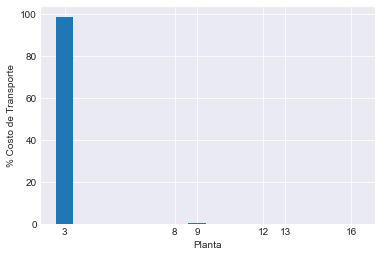

In [228]:
plt.figure(1)
plt.bar(x = df3_agrup.index.levels[0], height = df3_agrup[("Costo de transporte [USD]", "%")])
plt.xlabel("Planta")
plt.xticks(df3_agrup.index.levels[0])
plt.ylabel("% Costo de Transporte");

*Estadística Descriptiva del Costo Total [USD]*

$$ Z_{ipj} = min \sum_{k}{(X_{ki} + \sum_{c}{...\sum_{m}{Y_{ikpjcstm}}})} $$

In [229]:
df3["Costo total [USD]"] = df3["Costo de almacenaje [USD]"] + df3["Costo de transporte [USD]"]
df3_agrup = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo total [USD]": ["min", "mean", "max", "sum"]})

total = df3_agrup[("Costo total [USD]", "sum")].sum()
porcentaje = lambda x: x / total * 100

df3_agrup[("Costo total [USD]", "%")] = df3_agrup[("Costo total [USD]", "sum")].apply(porcentaje)
df3_agrup.round(2)

Costo total [USD]            \
                                                        min      mean   
Planta Puerto de origen Puerto de destino                               
3      4                9                            123.11  11063.88   
8      4                9                            445.86   3823.07   
9      4                9                           1591.66  85838.74   
12     4                9                            192.14   1002.17   
13     4                9                            121.62   3439.12   
16     9                9                            570.74    734.38   

                                                                             
                                                   max           sum      %  
Planta Puerto de origen Puerto de destino                                    
3      4                9                  15314774.90  1.524602e+09  98.48  
8      4                9                     14871.84  3.861298e+06   0.25  
9      4                9                    783738.30  1.030065e+07   0.67  
12     4                9                     15150.55  6.403891e+06   0.41  
13     4                9                    212913.25  2.957642e+06   0.19  
16     9                9                      1613.20  2.496891e+04   0.00

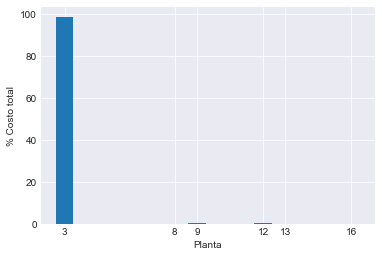

In [230]:
plt.figure(1)
plt.bar(x = df3_agrup.index.levels[0], height = df3_agrup[("Costo total [USD]", "%")])
plt.xlabel("Planta")
plt.xticks(df3_agrup.index.levels[0])
plt.ylabel("% Costo total");